In [1]:
import sklearn as skl
import pickle as pkl
import pandas as pd
import numpy as np

import sklearn.model_selection
import sklearn.svm
import sklearn.metrics

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import seaborn as sns

from itertools import chain

In [2]:
import scanpy as sc

adata = sc.read_h5ad('../examples/data/demo1_sp_adata.h5ad')

chosen_slices = ['MsBrainAgingSpatialDonor_5_0', 'MsBrainAgingSpatialDonor_6_0', 
                 'MsBrainAgingSpatialDonor_7_0']

adata = adata[adata.obs['donor_slice'].isin(chosen_slices), :]

C:\Users\lshh\miniconda3\envs\py39_integration\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [9]:
adata.obs['cell_type'].value_counts().index

CategoricalIndex(['neuron', 'oligodendrocyte', 'medium spiny neuron',
                  'astrocyte', 'endothelial cell', 'inhibitory interneuron',
                  'microglial cell', 'pericyte',
                  'oligodendrocyte precursor cell',
                  'vascular leptomeningeal cell', 'cell', 'macrophage',
                  'T cell'],
                 categories=['cell', 'T cell', 'endothelial cell', 'astrocyte', ..., 'pericyte', 'oligodendrocyte precursor cell', 'medium spiny neuron', 'vascular leptomeningeal cell'], ordered=False, dtype='category', name='cell_type')

In [18]:
adata.raw.var.index = adata.var['feature_name']

In [19]:
sc.tl.rank_genes_groups(adata, 'cell_type', groups=['neuron', 'oligodendrocyte', 'medium spiny neuron',
                  'astrocyte', 'endothelial cell', 'inhibitory interneuron',
                  'microglial cell', 'pericyte',
                  'oligodendrocyte precursor cell',
                  'vascular leptomeningeal cell', 'cell', 'macrophage'])

In [33]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names', 'pvals', 'logfoldchanges']})

,neuron_names,neuron_logfoldchanges
0,Slc17a7,42.723984
1,Rapgefl1,6.720965
2,Satb2,6.991593
3,Grin2b,4.625781
4,Tbr1,6.793841
...,...,...
369,Slc32a1,-3.709200
370,Sox10,-4.288555
371,Apoe,-5.172847
372,Clic4,-3.751702


In [27]:
import gseapy as gp
from gseapy import Msigdb # Note: 1.0.6 required. bioconda on Windows only has 0.9.5.

msig = Msigdb()
# mouse hallmark gene sets
gmt = msig.get_gmt(category='mh.all', dbver="2023.1.Mm")

C:\Users\lshh\miniconda3\envs\py39_integration\lib\site-packages\gseapy\msigdb.py:20: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  d = pd.read_html(resp.text)[0]
C:\Users\lshh\miniconda3\envs\py39_integration\lib\site-packages\gseapy\msigdb.py:72: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  d = pd.read_html(resp.text)[0]


## Pre-ranked

In [49]:
gene_list = degs[['neuron_names', 'neuron_logfoldchanges']]
gene_list.index = gene_list['neuron_names']
gene_list = gene_list[['neuron_logfoldchanges']]
gene_list

,neuron_logfoldchanges
neuron_names,
Slc17a7,42.723984
Rapgefl1,6.720965
Satb2,6.991593
Grin2b,4.625781
Tbr1,6.793841
...,...
Slc32a1,-3.709200
Sox10,-4.288555
Apoe,-5.172847


In [50]:
pre_res = gp.prerank(rnk=gene_list, # or rnk = rnk,
                     gene_sets=gmt,
                     threads=4,
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=True, # see what's going on behind the scenes
                    )

2023-10-02 03:36:15,810 [INFO] Parsing data files for GSEA.............................
2023-10-02 03:36:15,812 [INFO] 0025 gene_sets have been filtered out when max_size=1000 and min_size=5
2023-10-02 03:36:15,813 [INFO] 0025 gene_sets used for further statistical testing.....
2023-10-02 03:36:15,813 [INFO] Start to run GSEA...Might take a while..................
2023-10-02 03:36:15,866 [INFO] Congratulations. GSEApy runs successfully................



In [54]:
pre_res.res2d.head(10)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,HALLMARK_XENOBIOTIC_METABOLISM,-0.763635,-1.753707,0.039911,0.777072,0.328,6/8,19.25%,Apoe;Gad1;Vtn;Cyp27a1;Xdh;Tgfb2
1,prerank,HALLMARK_ESTROGEN_RESPONSE_EARLY,0.68065,1.563731,0.060932,0.681835,0.469,4/9,16.31%,Rapgefl1;Bcl11b;Deptor;Ncor2
2,prerank,HALLMARK_APICAL_SURFACE,0.703179,1.350965,0.097649,0.651474,0.764,2/5,4.01%,Sulf2;Scube1
3,prerank,HALLMARK_COAGULATION,-0.590081,-1.309827,0.183983,1.0,0.777,4/7,16.58%,Fn1;C1qa;Cd9;Sirt2
4,prerank,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,-0.488911,-1.287713,0.175055,0.894449,0.794,4/16,12.03%,Vim;Bgn;Fn1;Tgfb1
5,prerank,HALLMARK_ADIPOGENESIS,-0.635508,-1.280958,0.173278,0.687715,0.807,1/5,1.07%,Apoe
6,prerank,HALLMARK_ESTROGEN_RESPONSE_LATE,0.582429,1.190067,0.256364,0.788158,0.939,1/6,1.07%,Rapgefl1
7,prerank,HALLMARK_MYOGENESIS,0.421204,1.028632,0.390909,1.0,0.991,3/12,11.23%,Mef2c;Sptan1;Lsp1
8,prerank,HALLMARK_KRAS_SIGNALING_UP,-0.375562,-0.957341,0.445175,1.0,0.983,3/11,14.71%,Il33;Igf2;Ctss
9,prerank,HALLMARK_APICAL_JUNCTION,-0.44019,-0.90458,0.580931,1.0,0.992,1/5,1.34%,Cldn5


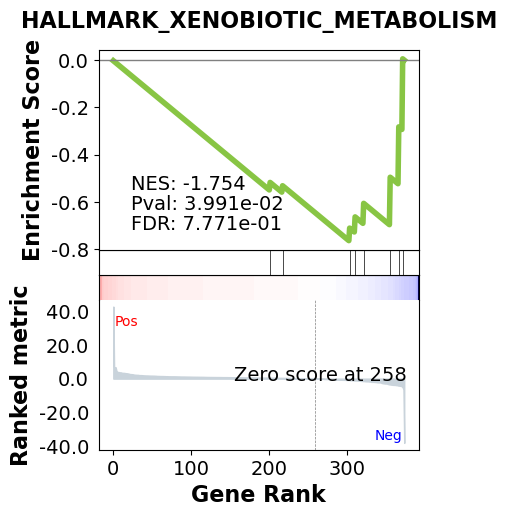

In [73]:
terms = pre_res.res2d.Term
axs = pre_res.plot(terms=terms[0])

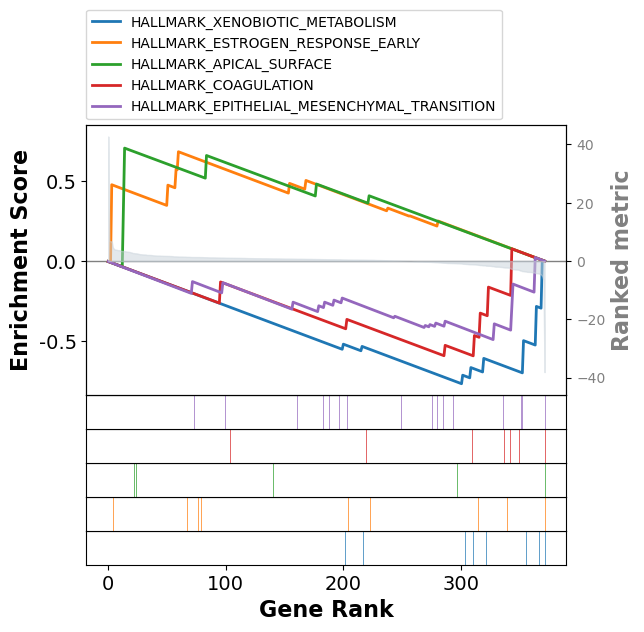

In [80]:
terms = pre_res.res2d.Term
axs = pre_res.plot(terms=terms[:5])

## Single-cell

In [85]:
sub_adata = adata[adata.obs['cell_type'].isin(['neuron', 'oligodendrocyte']), :]

C:\Users\lshh\miniconda3\envs\py39_integration\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [86]:
data=sub_adata.to_df().T
data.index = data.index.astype(str)

In [87]:
res = gp.gsea(data, # row -> genes, column-> samples
        gene_sets=gmt,
        cls=sub_adata.obs.cell_type,
        permutation_num=1000,
        permutation_type='phenotype',
        outdir=None,
        method='s2n', # signal_to_noise
        threads=6)

C:\Users\lshh\miniconda3\envs\py39_integration\lib\site-packages\gseapy\gsea.py:116: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_std = df.groupby(by=cls_dict, axis=1).std(numeric_only=True)


In [72]:
res.res2d.head(10)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,HALLMARK_ALLOGRAFT_REJECTION,0.343703,1.146059,0.261811,1.0,0.494,21/30,54.01%,Cd47;Il2ra;Cd74;Ccnd2;Il2rg;Cdkn2a;Il2rb;B2m;I...
1,gsea,HALLMARK_COMPLEMENT,0.398609,1.113551,0.321285,0.794625,0.544,2/15,4.01%,Kcnip3;Kcnip2
2,gsea,HALLMARK_INTERFERON_GAMMA_RESPONSE,0.302363,0.936298,0.531828,0.903008,0.736,11/20,50.00%,Ifi44;Il15ra;Cd74;Il2rb;B2m;Nfkb1;Fcgr1;Il6;Cx...
3,gsea,HALLMARK_INFLAMMATORY_RESPONSE,0.250927,0.757188,0.800797,1.0,0.87,11/19,50.00%,Il15ra;Il2rb;Nfkb1;Il7r;Il1b;Nlrp3;Il6;Cxcl10;...
4,gsea,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,-0.223464,-0.674506,0.884774,0.890154,0.965517,16/16,78.88%,Vim;Tgfb1;Lama1;Fbn2;Adam12;Bgn;Tnc;Col11a1;Fn...
5,gsea,HALLMARK_TNFA_SIGNALING_VIA_NFKB,0.166992,0.495336,0.994059,0.993033,0.926,10/18,58.82%,Nr4a2;Il15ra;Nfkb1;Il7r;Il1b;Il6;Cxcl10;Cdkn1a...


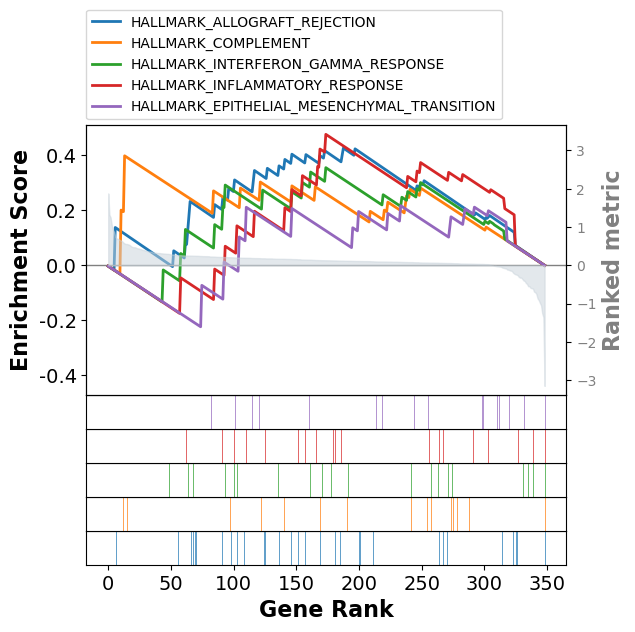

In [79]:
terms = res.res2d.Term
axs = res.plot(terms=terms[:5])

## Plots

C:\Users\lshh\miniconda3\envs\py39_integration\lib\site-packages\gseapy\plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
C:\Users\lshh\AppData\Local\Temp\ipykernel_24796\1375977973.py:9: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


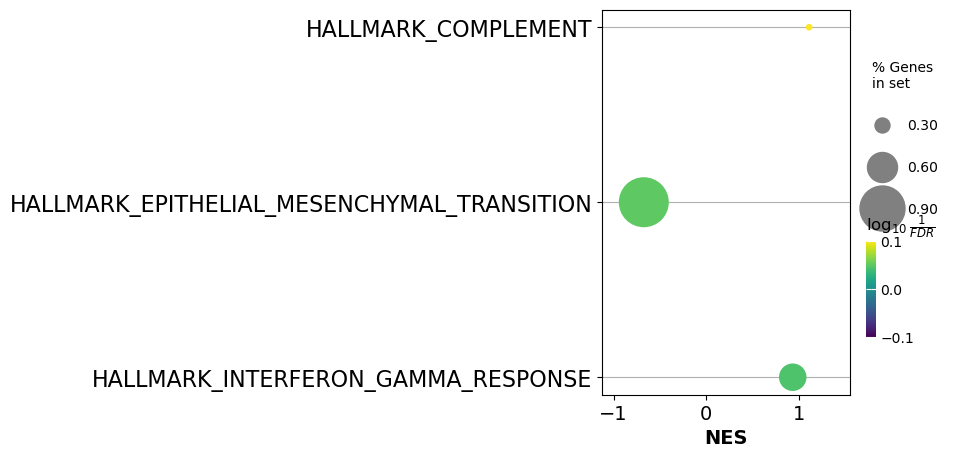

In [78]:
from gseapy import dotplot
# to save your figure, make sure that ``ofname`` is not None
ax = dotplot(res.res2d,
             column="FDR q-val",
             title='',
             cmap=plt.cm.viridis,
             size=6, # adjust dot size
             figsize=(4,5), cutoff=0.99, show_ring=False)
plt.tight_layout()